# Efficient Frontier

The efficient frontier is the Pareto-optimal curve representing the best attainable trade-off between expected return and risk. Every point on this frontier dominates all other feasible portfolios by offering a higher return for the same risk (or lower risk for the same return), making it the gold standard for comparing asset allocation strategies.

Constructing this frontier requires solving hundreds of portfolio optimization problems, typically by sweeping across different risk-aversion parameters or target return levels. This computational intensity makes solver performance pivotal, as each speedup compounds. Leveraging a GPU solver like cuOpt dramatically accelerates this iterative workflow, significantly cutting runtime compared to CPU-only approaches.

In this notebook, we generate the efficient frontier by iterating over different risk aversion levels. We can compare the overall performance using cuOpt GPU solver vs. a CPU solver and see how the speed-up on a single optimization problem multiplies in one of the advanced, practical workflows. 

In [1]:
import os
from cufolio import utils, cvar_utils
from cufolio.cvar_parameters import CvarParameters
import cvxpy as cp

In [2]:
# Define CVaR optimization parameters for Efficient Frontier (EF) construction
ef_cvar_params = CvarParameters(
    w_min=0.0, w_max=1.0,             # Asset weight bounds (no shorting)
    c_min=0.0, c_max=0.0,             # Cash holdings bounds (no cash allocation)
    L_tar=1.0,                        # Leverage target (fully invested; sum of weights equals 1 for long only)
    T_tar=None,                       # No turnover constraint
    cvar_limit=None,                  # Maximum CVaR (unconstrained)
    risk_aversion=1,                  # Base risk aversion (varied to generate the efficient frontier)
    confidence=0.95,                  # CVaR confidence level
)

In [3]:
# User inputs for efficient frontier example
ef_dataset_name = "sp500"

# Get date range and file path
ef_regime = "recent"
ef_range = ('2022-01-01', '2024-07-01')
ef_regime_dict = {"name": ef_regime, "range": ef_range}
ef_dataset_path = f"../data/stock_data/{ef_dataset_name}.csv"

# define the settings for computing returns and scenario generation
ef_returns_compute_settings = {'return_type': 'LOG', 'freq': 1}
ef_scenario_generation_settings = {'num_scen': 10000, # Number of return scenarios to simulate 
                                'fit_type': 'kde', 
                                'kde_settings': {'bandwidth': 0.01, 
                                                 'kernel': 'gaussian', 
                                                 'device': 'GPU'
                                                 },
                                'verbose': False
                                }

# Compute returns for the efficient frontier
ef_returns_dict = utils.calculate_returns(ef_dataset_path, ef_regime_dict, ef_returns_compute_settings)
ef_returns_dict = cvar_utils.generate_cvar_data(ef_returns_dict, ef_scenario_generation_settings)

# Using `create_efficient_frontier`

`create_efficient_frontier` sweeps risk-aversion levels, solves the CVaR problem, and returns the frontier plot along with the DataFrame of optimal portfolios. Use it to orchestrate the entire efficient frontier workflow with the following options in mind:

- **Core inputs**: provide `input_file_name`, `regime_dict`, `return_type`, `cvar_params`, and a `solver_settings` dict describing the backend (e.g. `{"solver": cp.CUOPT, "verbose": False}`).
- **Risk-aversion sweep**: set `ra_num` for how many risk-aversion values to evaluate and `min_risk_aversion`/`max_risk_aversion` for the logarithmic bounds; more points produce a smoother frontier.
- **Portfolio overlays**: use `custom_portfolios_dict` and the `benchmark_portfolios` flag to annotate custom or benchmark allocations on the plot.
- **Discrete comparisons (Optional)**: toggle `show_discretized_portfolios` and tune `discretization_params` (`weight_discretization`, `max_assets`, `min_weight`, `max_weight`, `sum_to_one`) to include exhaustive combinatorial portfolios. Note that this approach is extremely time consuming as it involves parsing through weight_discretization^num_assets: first check if it satisfies the self-financing requirements (all weights sum to 1) and then evaluate the risk and return of each valid portfolio. 
- **Presentation tweaks**: adjust `notional`, `style`, `color_scheme`, `dpi`, and `save_path` to control scaling and exported figures.
- **Outputs**: returns `(results_df, fig, ax)` so you can persist results, customize Matplotlib visuals, or reuse the frontier data downstream.

The next cell demonstrates a baseline call — modify the parameters above to experiment with different datasets, solver configurations, or visualization styles. We also evaluate and dsiplay a custom portfolio on the same plot, and one can check that at the same risk level, the optimized portfolio achieves much higher returns. 

In [ ]:
# Efficient Frontier (EF) Settings

# Optional: Define custom portfolios to display on the EF plot
ef_custom_portfolios_dict = {
    "AAPL-LLY-MSFT portfolio": ({"AAPL": 0.3, "LLY": 0.2, "MSFT": 0.5}, 0.0) # ({asset_weights_dict}, cash_holding_float)
}

ef_plot_title = f"Efficient Frontier Plot – {ef_dataset_name} ({ef_regime})"
ef_output_folder = "../results/EF_results/" # Folder to save EF results
ef_results_csv_path = os.path.join(ef_output_folder, "EF_results.csv")
ef_plot_png_path = os.path.join(ef_output_folder, "EF_plot.png")

# Range for risk aversion parameter (lambda_risk)
ef_min_risk_aversion_exp = -3         # Corresponds to 1e-3 (high risk appetite)
ef_max_risk_aversion_exp = 1          # Corresponds to 1e1 = 10 (risk-averse)
ef_risk_aversion_steps = 30           # Number of riskaversion levels for a smoother EF

# Prepare output directory
os.makedirs(ef_output_folder, exist_ok=True)

Computing efficient frontier with 30 portfolios...
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1


Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
   ✓ Completed 10/30 portfolios
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console to false
Setting parameter method to 1
Setting parameter log_to_console

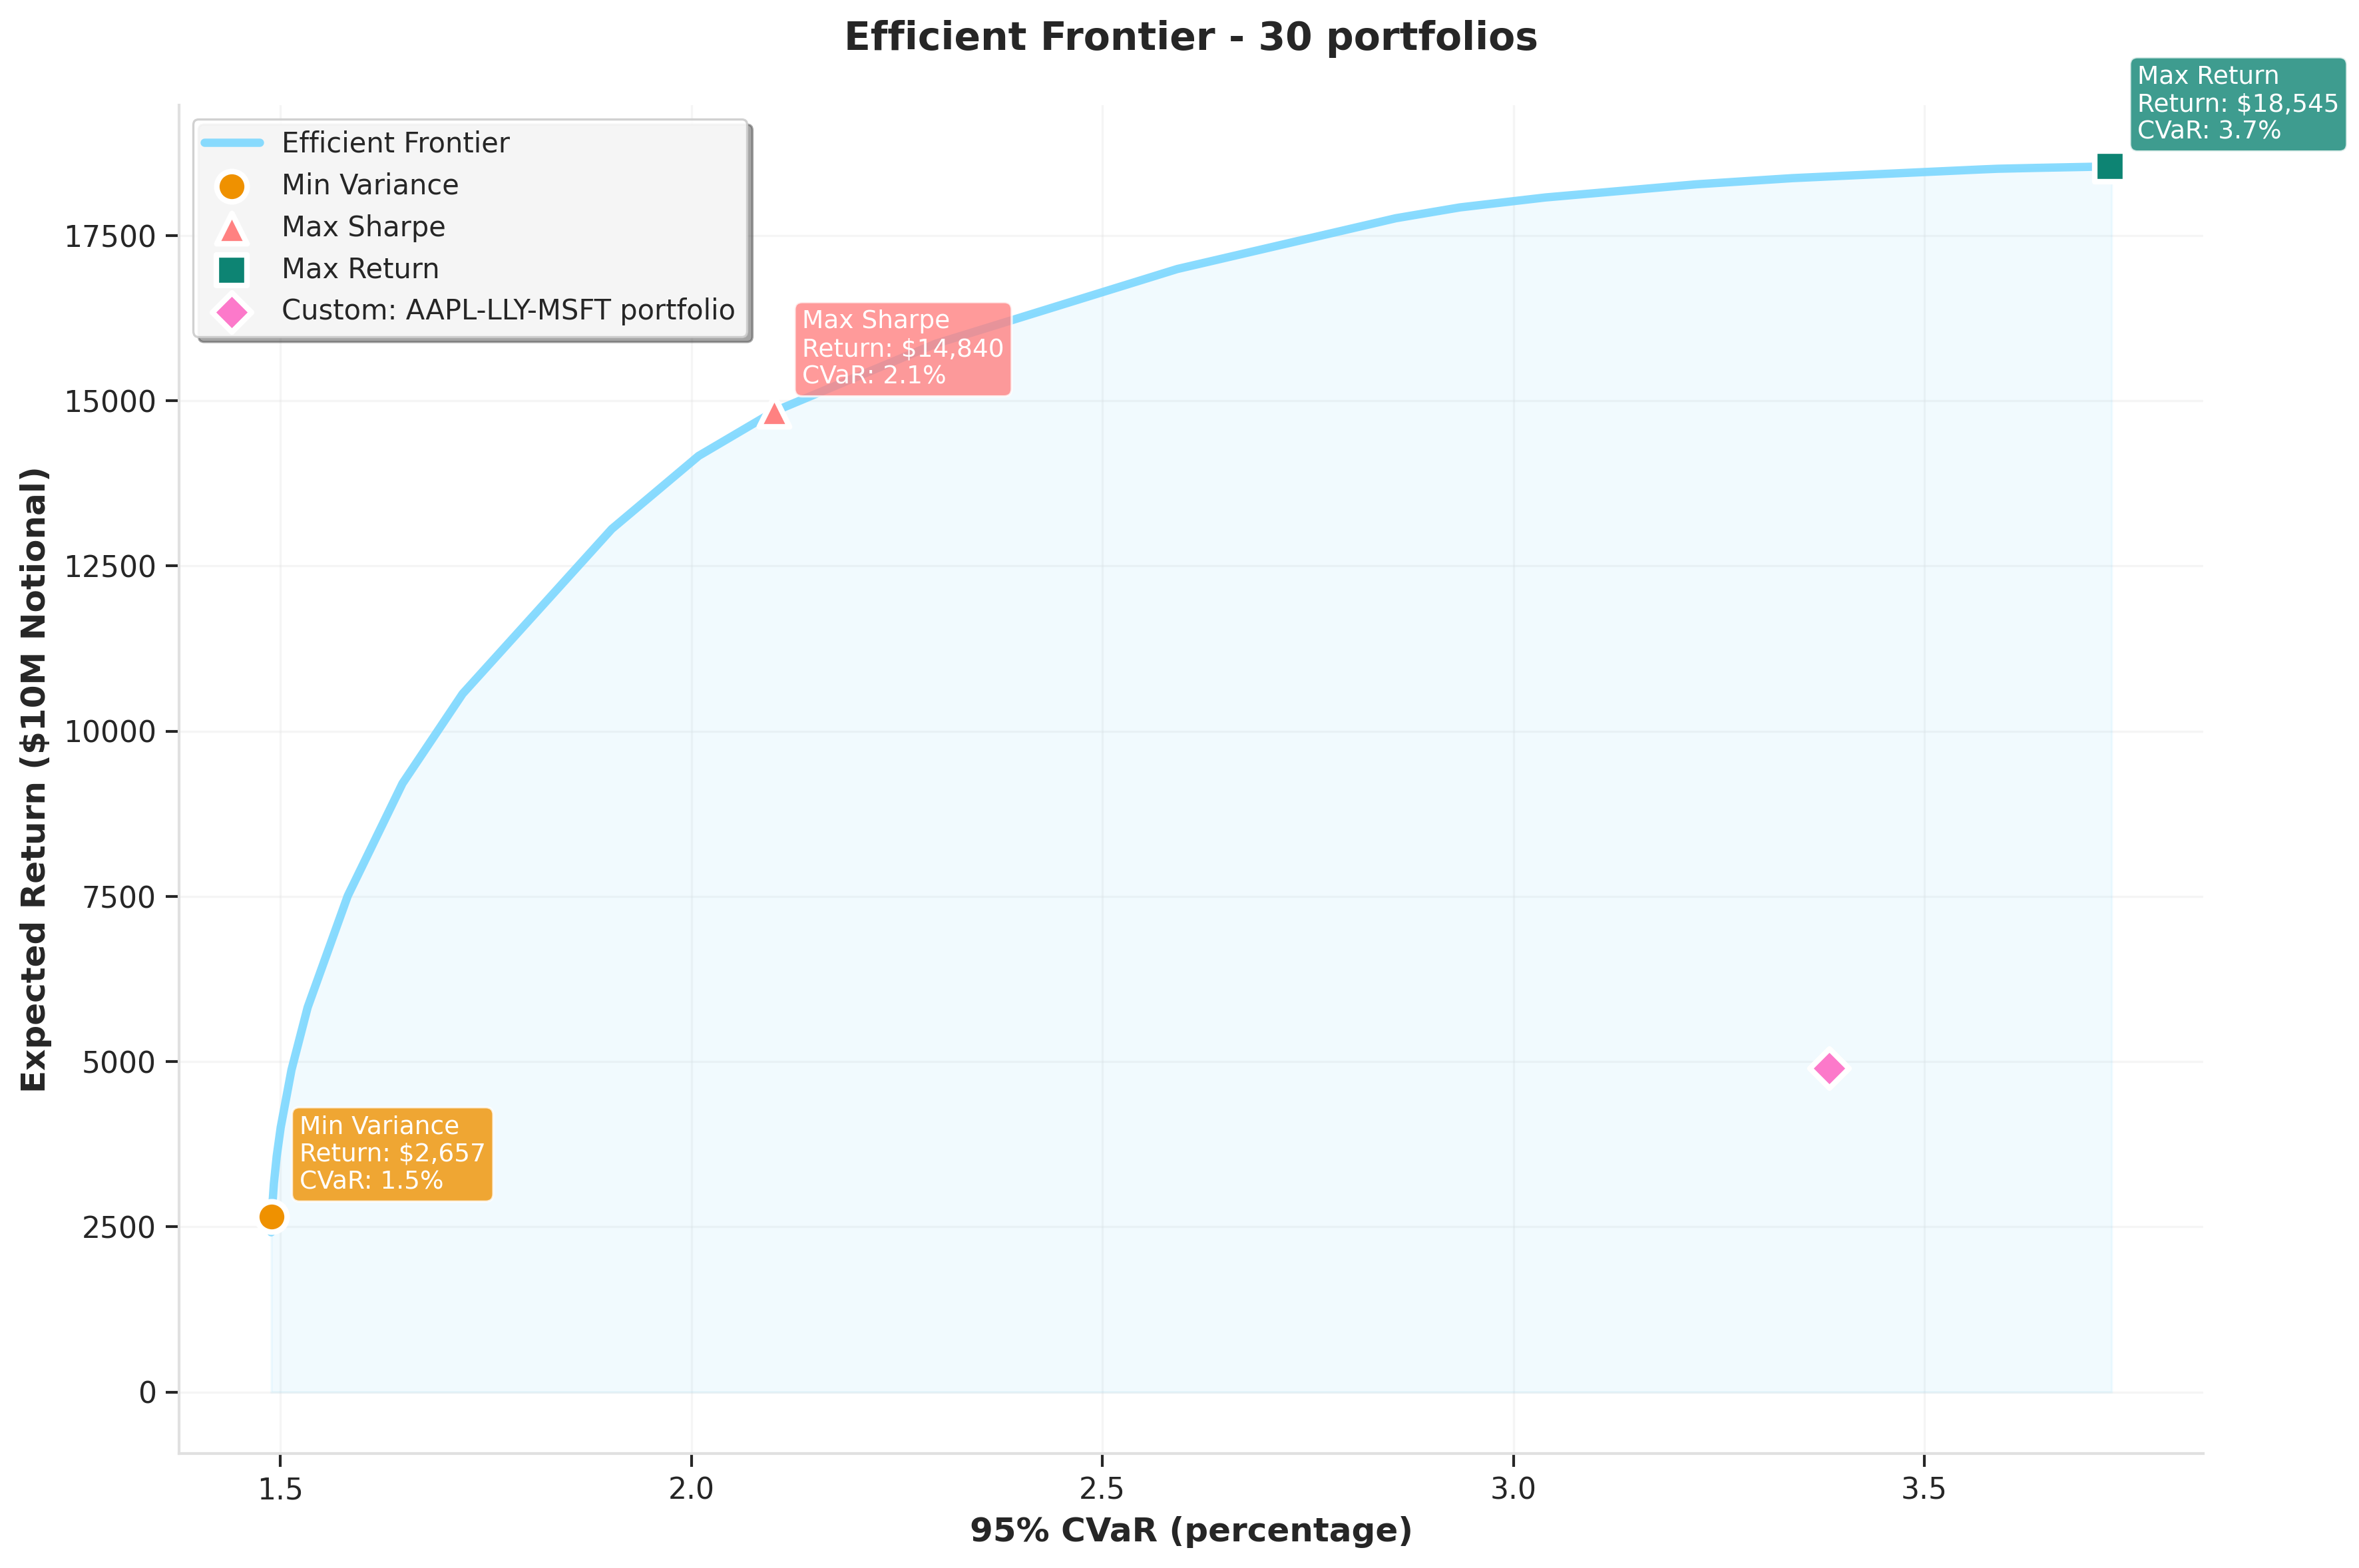

Efficient frontier analysis complete!


In [ ]:
# Define solver settings
ef_solver_settings = {"solver": cp.CUOPT, "verbose": False, 'solver_method': 'PDLP'}

# Create efficient frontier and generate the plot
results_df, fig, ax = cvar_utils.create_efficient_frontier(
    ef_returns_dict,
    ef_cvar_params,
    ef_solver_settings,
    custom_portfolios_dict = ef_custom_portfolios_dict,
    ra_num = ef_risk_aversion_steps,
    min_risk_aversion = ef_min_risk_aversion_exp,
    max_risk_aversion = ef_max_risk_aversion_exp,
    save_path = None,
    show_discretized_portfolios = False, #optional to turn on, but very time consuming
    #discretization_params={
    #    "weight_discretization": 50,
    #    "min_weight": ef_cvar_params.w_min,
    #    "max_weight": ef_cvar_params.w_max
    #},
    print_portfolio_results = False,
    show_plot = True
)

In [6]:
# Display results
results_df

,regime,solver,solve time,return,CVaR,obj,risk_aversion,variance,volatility,sharpe
0,recent,CUOPT,0.272733,0.000242,0.014890,0.148655,10.000000,0.000054,0.007325,0.524004
1,recent,CUOPT,0.194469,0.000246,0.014890,0.108140,7.278954,0.000054,0.007322,0.533812
2,recent,CUOPT,0.187210,0.000250,0.014890,0.078643,5.298317,0.000054,0.007320,0.541378
3,recent,CUOPT,0.188212,0.000257,0.014892,0.057177,3.856620,0.000054,0.007319,0.556612
4,recent,CUOPT,0.180281,0.000266,0.014895,0.041548,2.807216,0.000054,0.007319,0.576315
5,recent,CUOPT,0.186138,0.000283,0.014904,0.030170,2.043360,0.000054,0.007326,0.613517
6,recent,CUOPT,0.192251,0.000316,0.014922,0.021879,1.487352,0.000054,0.007350,0.681690
7,recent,CUOPT,0.201109,0.000357,0.014956,0.015835,1.082637,0.000054,0.007375,0.768576
8,recent,CUOPT,0.211997,0.000401,0.015005,0.011424,0.788046,0.000055,0.007401,0.859538
9,recent,CUOPT,0.212806,0.000487,0.015136,0.008195,0.573615,0.000056,0.007465,1.036552


SPDX-FileCopyrightText: Copyright (c) 2023-2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved. 

SPDX-License-Identifier: Apache-2.0

Licensed under the Apache License, Version 2.0 (the "License");you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0. Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.